# 1. Image recognition

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel

c:\Users\Annek\Documents\pytho exos\Phoetry\Phoetry_2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Initialize model
model_id="openai/clip-vit-base-patch32"

processor=CLIPProcessor.from_pretrained(model_id)
model=CLIPModel.from_pretrained(model_id)

In [3]:
#Setup
device="cuda" if torch.cuda.is_available() else "cpu"
#Move model to device
model.to(device)
device

'cpu'

In [4]:
#Categories
nature_categories=["tree","flower","sunset","sunrise","cloud","mountain","beach","river","lake","waterfall","forest","grassland","desert","rain","snow",
                   "road","traffic jam","hill","valley","cave","farm","garden","coastline","field","pond","sky","animal","insect","fungi",
                   "reaf","pebble","stone", "dog", "cat","bird","butterfly","bee", "stars","moon","sun"]
#generate sentences
clip_labels=[f"a photo of a {label}" for label in nature_categories ]

In [5]:
#Create label tokens
label_tokens=processor(
    text=clip_labels,
    padding=True,
    images=None,
    return_tensors='pt'
).to(device)

In [6]:
#encode tokens to sentence embeddings
label_emb=model.get_text_features(**label_tokens)
#detach from pytorch gradient computation
label_emb=label_emb.detach().cpu().numpy()

In [7]:

image_folder_path="C:/Users/Annek/Documents/pytho exos/Phoetry/Phoetry/images"

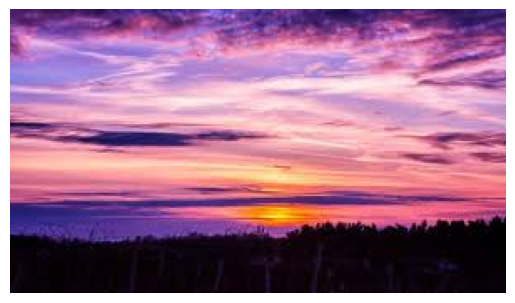

In [8]:
#Load images to test
# Load the image
test_image = mpimg.imread(image_folder_path+"/sunset.jpg")

# Display the image
plt.imshow(test_image)
plt.axis("off")  # Hide axes
plt.show()

In [9]:
sunset=processor(
    text=None,
    images=test_image,
    return_tensors='pt'
)["pixel_values"].to(device)
sunset.shape

torch.Size([1, 3, 224, 224])

In [10]:
#embedding
sunset_emb=model.get_image_features(sunset)
sunset_emb.shape

torch.Size([1, 512])

In [11]:
sunset_emb=sunset_emb.detach().cpu().numpy()
scores=np.dot(sunset_emb,label_emb.T)
scores.shape

(1, 40)

In [12]:
label_prediction=np.argsort(scores)[-5:]

In [13]:
top5_label_prediction=list(np.argsort(scores)[0][-3:,][::-1])
np.array(nature_categories)[top5_label_prediction].tolist()

['sky', 'sunset', 'sunrise']

In [14]:
#Predict label function
def image_label_detector(image_path):
    """ 
    Take the image path in input and predict the 3 most probable labels
    """

    image = mpimg.imread(image_path)#Load image
    processed_image=processor( #Process image
    text=None,
    images=image,
    return_tensors='pt'
)["pixel_values"].to(device)
    image_emb=model.get_image_features(processed_image).detach().cpu().numpy() #embedding
    scores=np.dot(image_emb,label_emb.T) #predicted lables scores (among the 39 original labels)
    top3_scores_indexes=list(np.argsort(scores)[0][-3:,][::-1])

    return np.array(nature_categories)[top3_scores_indexes].tolist()
    


In [15]:
from src.image_recognition import image_label_detector
#Proposed labels
image_path=image_folder_path+"/sunset.jpg"
top3_predicted_labels=image_label_detector(image_path,nature_categories)

# 2. Text generation

In [ ]:
from datasets import load_dataset, DatasetDict,concatenate_datasets, Dataset
from transformers import GPT2Tokenizer,GPT2LMHeadModel,Trainer, TrainingArguments, DataCollatorForLanguageModeling
import kagglehub

In [2]:
#Load dataset
foundation_poems = load_dataset("shahules786/PoetryFoundationData")
foundation_poems

DatasetDict({
    train: Dataset({
        features: ['poem name', 'content', 'author', 'type', 'age'],
        num_rows: 13854
    })
})

In [4]:
import pandas as pd

In [7]:


# Download latest version
mexwell_poems = pd.read_csv(f"{kagglehub.dataset_download("mexwell/poem-dataset")}/final_df_emotions(remove-bias).csv")
mexwell_poems["author"]="unknown"
mexwell_poems=mexwell_poems[["label","poem content","author","type","age"]]
mexwell_poems.columns=['poem name', 'content', 'author', 'type', 'age']
mexwell_poems


,poem name,content,author,type,age
0,sadness,Let the bird of loudest lay\r\nOn the sole Ara...,unknown,Mythology & Folklore,Renaissance
1,anger,"Sir Charles into my chamber coming in,\r\nWhen...",unknown,Mythology & Folklore,Renaissance
2,anger,"Our vice runs beyond all that old men saw,\r\n...",unknown,Mythology & Folklore,Renaissance
3,anger,"Lo I the man, whose Muse whilome did maske,\r\...",unknown,Mythology & Folklore,Renaissance
4,sadness,"Long have I longd to see my love againe,\r\nSt...",unknown,Mythology & Folklore,Renaissance
...,...,...,...,...,...
445,fear,This youth too long has heard the break\r\nOf ...,unknown,Love,Modern
446,fear,Making his advances\r\nHe does not look at her...,unknown,Love,Modern
447,fear,"I thought he was dumb,\r\nI said he was dumb,\...",unknown,Love,Modern
448,anger,"With the man I love who loves me not,\r\nI wal...",unknown,Love,Modern


In [10]:
abiemo_poems = pd.read_csv(f"{kagglehub.dataset_download("pkkazipeta143/americanbritishindian-emotion-poetry-dataset")}/ABIEMO_2334.csv")
abiemo_poems["author"]="unknown"
abiemo_poems["age"]="unknown"
abiemo_poems=abiemo_poems[["Emotions","poems","author","class","age"]]
abiemo_poems.columns=['poem name', 'content', 'author', 'type', 'age']
abiemo_poems


,poem name,content,author,type,age
0,Fear,A History Of Paisley:\n\nYou who will find the...,unknown,i,unknown
1,Fear,\nA Pastoral\n\non the wall the dense ivy of e...,unknown,i,unknown
2,Surprise,\nPrayer Rug\n\nThose intervals between the da...,unknown,i,unknown
3,Fear,"\nShaving\n\nIn the mirror, the hand hacks at ...",unknown,i,unknown
4,Sad,\nSnow on the Desert\n\nEach ray of sunshine i...,unknown,i,unknown
...,...,...,...,...,...
2329,Sad,Wilful Missing Deserters There is a worl...,unknown,b,unknown
2330,Fear,With Drake In The Tropics South and far south ...,unknown,b,unknown
2331,Sad,With Scindia To Delhi More than a hundred year...,unknown,b,unknown
2332,Surprise,Yet At The Last Yet at the last ere our spearm...,unknown,b,unknown


In [14]:
poems=DatasetDict()
poems["train"]=concatenate_datasets(
    [
     foundation_poems["train"],
     Dataset.from_pandas(mexwell_poems),
     Dataset.from_pandas(abiemo_poems)
    ]
)
poems

DatasetDict({
    train: Dataset({
        features: ['poem name', 'content', 'author', 'type', 'age'],
        num_rows: 16638
    })
})

In [4]:
#Initialize model
model_name='gpt2'
tokenizer=GPT2Tokenizer.from_pretrained(model_name)
model=GPT2LMHeadModel.from_pretrained(model_name)

In [5]:
#create a tokenize function
def tokenize_function(dataset):
    poem=dataset["content"]
    tokenizer.truncation_side="left"
    tokenized_inputs=tokenizer(
        poem,
        return_tensors="pt",
        truncation=True,
        
        padding=True,
        max_length=512

    )
    return tokenized_inputs
#add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token":"[PAD]"})
    model.resize_token_embeddings(len(tokenizer))

tokenized_poems=poems["train"].map(tokenize_function,batched=True)
tokenized_poems

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`
Map: 100%|██████████| 13854/13854 [00:28<00:00, 493.34 examples/s]


Dataset({
    features: ['poem name', 'content', 'author', 'type', 'age', 'input_ids', 'attention_mask'],
    num_rows: 13854
})

In [6]:
data_collator=DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    return_tensors='pt',
    mlm=False
)

In [7]:
# Set up the training arguments
training_args = TrainingArguments(
    output_dir='./trained_model',          # output directory for model checkpoints
    do_eval=False,     # evaluate every few steps
    learning_rate=5e-5,              # learning rate for optimizer
    per_device_train_batch_size=2,   # batch size for training
    num_train_epochs=2,              # number of training epochs
    save_steps=10_000,               # save checkpoints every 10,000 steps
    save_total_limit=5,              # only keep the 2 most recent checkpoints
    logging_dir='./logs',            # directory to save logs
    logging_steps=500,               # log every 500 steps
    report_to=None,
    no_cuda=False,  # If False, forces GPU usage (set True if you want CPU)
    fp16=True,  # Use mixed precision for speedup (if using GPU
)
class CausalLMTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False,num_items_in_batch=None):
        # Ensure we set up the labels correctly for causal language modeling
        labels = inputs.get("input_ids").clone()  # Set labels as input_ids for causal language modeling
        outputs = model(**inputs)
        loss = outputs.loss  # Get the loss from model outputs
        return (loss, outputs) if return_outputs else loss
    
# Set up the Trainer
trainer = CausalLMTrainer(
    model=model,                         # the model to train
    args=training_args,                  # training arguments
    train_dataset=tokenized_poems,          # training data        
    data_collator=data_collator
)

# Train the model
trainer.train()

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
500,3.698500
1000,3.522100
1500,3.548100
2000,3.512400
2500,3.499200
3000,3.487700
3500,3.455600
4000,3.442600
4500,3.425300
5000,3.411200


TrainOutput(global_step=13854, training_loss=3.368771603290904, metrics={'train_runtime': 86965.3612, 'train_samples_per_second': 0.319, 'train_steps_per_second': 0.159, 'total_flos': 7239879622656000.0, 'train_loss': 3.368771603290904, 'epoch': 2.0})

In [ ]:
#Save model
model.save_pretrained("trained_model/poet-gpt2")



In [15]:
tokenizer.save_pretrained("trained_model/poet-gpt2")

('trained_model/poet-gpt2\\tokenizer_config.json',
 'trained_model/poet-gpt2\\special_tokens_map.json',
 'trained_model/poet-gpt2\\vocab.json',
 'trained_model/poet-gpt2\\merges.txt',
 'trained_model/poet-gpt2\\added_tokens.json')

In [16]:
model_path = "trained_model/poet-gpt2"  # Update if you saved the model elsewhere
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)

# Set model to evaluation mode
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50258, bias=False)
)

In [30]:
# Set up the initial prompt
prompt = "For I see the moon,"

# Encode the input
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Generate text
output = model.generate(
    input_ids,
    max_length=200,  # Adjust for longer or shorter poems
    temperature=0.5,  # Controls randomness (higher = more creative)
    top_k=60,         # Limits sampling pool for diversity
    top_p=0.9,        # Nucleus sampling for coherence
    repetition_penalty=1.5,  # Discourages word repetition
    do_sample=True,   # Enables sampling (for more creativity)
)

# Decode and print the poem
poem = tokenizer.decode(output[0], skip_special_tokens=True)
print(poem)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


For I see the moon, and it is not clear why; nor can I tell if it be a sign or a mark. The moon is shining in the evening light, but cannot be seen by me:—it is only that there are shadows on the ground above me, which make my eyes turn away from them to look at it.
                                                                                                                                
